In [1]:
from __future__ import annotations
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Value:
    def __init__(self, data: float | np.ndarray, _children=(), _op=''):
        self.data = data 
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data}, grad={self.grad})'

    def __getitem__(self, idx):
        if idx<0 or idx>len(self.data):
            raise IndexError(f"Row index {idx} out of range; must be in [0, {len(self.val)-1}]")

        return self.data[idx]

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        y = math.tanh(self.data)
        out = Value(y, (self,), 'tanh')

        def _backward():
            self.grad += (1 - y*y) * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)); 'Only accepting int, float'
        out = Value(self.data ** other, (self, ), '**') 
        
        def _backward():
            self.grad += other * (self.data) ** (other - 1) * out.grad

        out._backward = _backward
        return out

    def __matmul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
    
        A = self.data      # assume list of lists or 2D array
        B = other.data
    
        # infer shapes
        n_rows_A = len(A)
        n_cols_A = len(A[0])
        n_rows_B = len(B)
        n_cols_B = len(B[0])
    
        if n_cols_A != n_rows_B:
            raise ValueError(
                f"matmul shape mismatch: {n_rows_A}x{n_cols_A} @ {n_rows_B}x{n_cols_B}"
            )
        
        # allocate result (n_rows_A x n_cols_B)
        res = [[0.0 for _ in range(n_cols_B)] for _ in range(n_rows_A)]
    
        for i in range(n_rows_A):
            for j in range(n_cols_B):
                total = 0.0
                for k in range(n_cols_A):
                    total += A[i][k] * B[k][j]
                res[i][j] = total
    
        out = Value(res, (self, other), '@')
    
        def _backward():
            # dL/dA = dL/dOut @ B^T
            # dL/dB = A^T @ dL/dOut
            # but here out.grad will be matrix-shaped
            raise NotImplementedError("backward for matmul not implemented yet")
    
        out._backward = _backward
        return out

        
    def __neg__(self):
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def backward(self):
        visited = set()
        topo = []

        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build(child)
                topo.append(v)

        build(self)
        self.grad = 1.0
        for x in reversed(topo):
            x._backward()
           

# Testing Value class

In [3]:
a = Value(2)
c = Value(3)
b = Value(4)

d = a * b
f = d + c
f

Value(data=11, grad=0.0)

In [4]:
f.grad = 1

In [5]:
f._backward()
d

Value(data=8, grad=1.0)

In [6]:
d._backward()
d

Value(data=8, grad=1.0)

In [7]:
c._backward()

In [8]:
d._backward()

In [9]:
a._backward()
b._backward()

In [10]:
a,b,c,d,f # checking populations of grads

(Value(data=2, grad=8.0),
 Value(data=4, grad=4.0),
 Value(data=3, grad=1.0),
 Value(data=8, grad=1.0),
 Value(data=11, grad=1))

In [11]:
d._prev

{Value(data=2, grad=8.0), Value(data=4, grad=4.0)}

In [12]:
c = Value(3)
x = c ** 4 
x

Value(data=81, grad=0.0)

In [13]:
x.grad = 1
x._backward()
c._backward()
c

Value(data=3, grad=108.0)

In [14]:
x._prev

{Value(data=3, grad=108.0)}

In [15]:
a = Value(2)
b = Value(4)
c = Value(3)

d = a * b      # 8
f = d + c      # 11

f.backward()   # builds topo, sets f.grad=1, backprops

print(a, b, c) # grads: df/da = 4, df/db = 2, df/dc = 1

Value(data=2, grad=4.0) Value(data=4, grad=2.0) Value(data=3, grad=1.0)


In [16]:
mat1 = Value([[1, 2, 3], [4, 5, 6]]) 
mat2 = Value([[1, 2], [3, 4], [5, 6]])

mat1@mat2

Value(data=[[22.0, 28.0], [49.0, 64.0]], grad=0.0)

# making sure scalar autograd works

In [17]:
# creating dataset
# linear regression 

m = 3.2
bz = 5.7

x = np.arange(1.0, 10.0, 0.05)

y = m * x + bz

x.shape, y.shape , x[:5], y[:5]

((180,),
 (180,),
 array([1.  , 1.05, 1.1 , 1.15, 1.2 ]),
 array([8.9 , 9.06, 9.22, 9.38, 9.54]))

In [18]:
# train test split
split_size = int(len(x) * 0.8)

X_train, y_train = x[:split_size], y[:split_size]
X_test, y_test = x[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(144, 144, 36, 36)

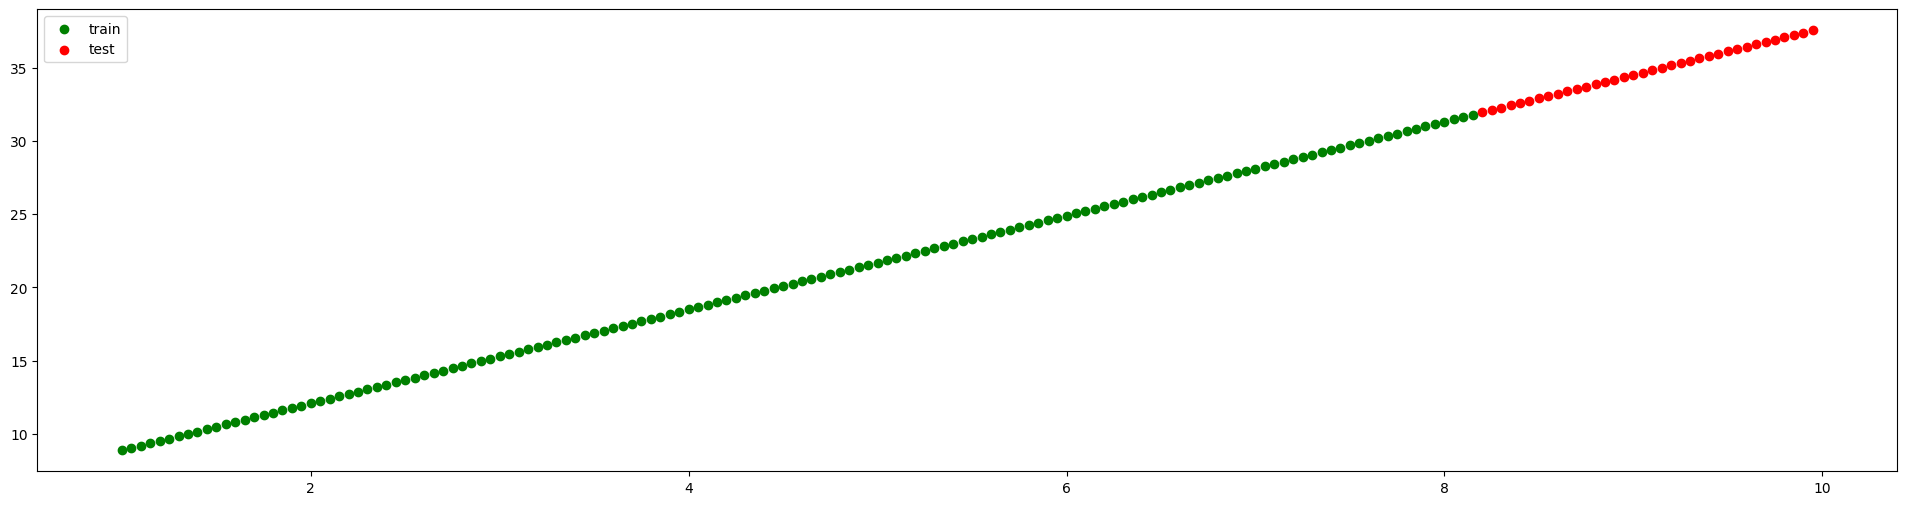

In [19]:
# visualizing the dataset

def plot(train: tuple, test: tuple = None, pred = None):
    X_train, y_train = train[0], train[1]

    if test is not None:
        X_test, y_test = test[0], test[1]

    # plot
    plt.figure(figsize=(24, 6))
    plt.scatter(X_train, y_train, c='g', label='train')
    if test is not None:
        plt.scatter(X_test, y_test, c='r', label='test')
    if pred is not None:
        plt.scatter(X_test, pred, c='y', label='pred')
    plt.legend()
    plt.show()


plot(train=(X_train, y_train), test=(X_test, y_test))

In [20]:
# error function for the regression model

def error(y_train, y_pred):
    # MSE
    error = y_pred - y_train
    return error * error

In [21]:
# model init --  weights and bias
# random
Wi = Value(np.random.randn())
bi = Value(np.random.randn())

print(Wi, bi)

Value(data=0.37600018171260585, grad=0.0) Value(data=1.7334789267124702, grad=0.0)


In [22]:
# training a tiny model on this 
epochs = 1000
N = len(X_train)
lr = 1e-2

for i in range(epochs):

    # zero grads
    Wi.grad = 0.0
    bi.grad = 0.0
    
    # forward pass
    loss = Value(0.0)
    
    for xi, yi in zip(X_train, y_train): # training on the full dataset
        y_pred = Wi * Value(float(xi)) + bi # scalar value
        # loss
        diff = error(Value(float(yi)), y_pred)
        loss += diff

    # avg
    loss = loss * Value(1 / N)
    
    
    # prints
    if i % 100 == 0:
        print(f'epoch: {i} | loss: {round(loss.data, 3)}')
        

    # backprop
    loss.backward()
    
    # gradient descent
    Wi.data -= lr * Wi.grad
    bi.data -= lr * bi.grad


epoch: 0 | loss: 319.598
epoch: 100 | loss: 0.983
epoch: 200 | loss: 0.506
epoch: 300 | loss: 0.261
epoch: 400 | loss: 0.134
epoch: 500 | loss: 0.069
epoch: 600 | loss: 0.036
epoch: 700 | loss: 0.018
epoch: 800 | loss: 0.009
epoch: 900 | loss: 0.005


In [23]:
# test 

y_p = []
test_loss = Value(0.0)
for xi, yi in zip(X_test, y_test):
    y_hat = Wi * Value(float(xi)) + bi
    y_p.append(y_hat.data)
    diff = error(Value(float(yi)), y_hat)
    test_loss += diff

loss_p = test_loss * Value(1.0/ len(X_test))
print(loss_p)

Value(data=0.006420443377704587, grad=0.0)


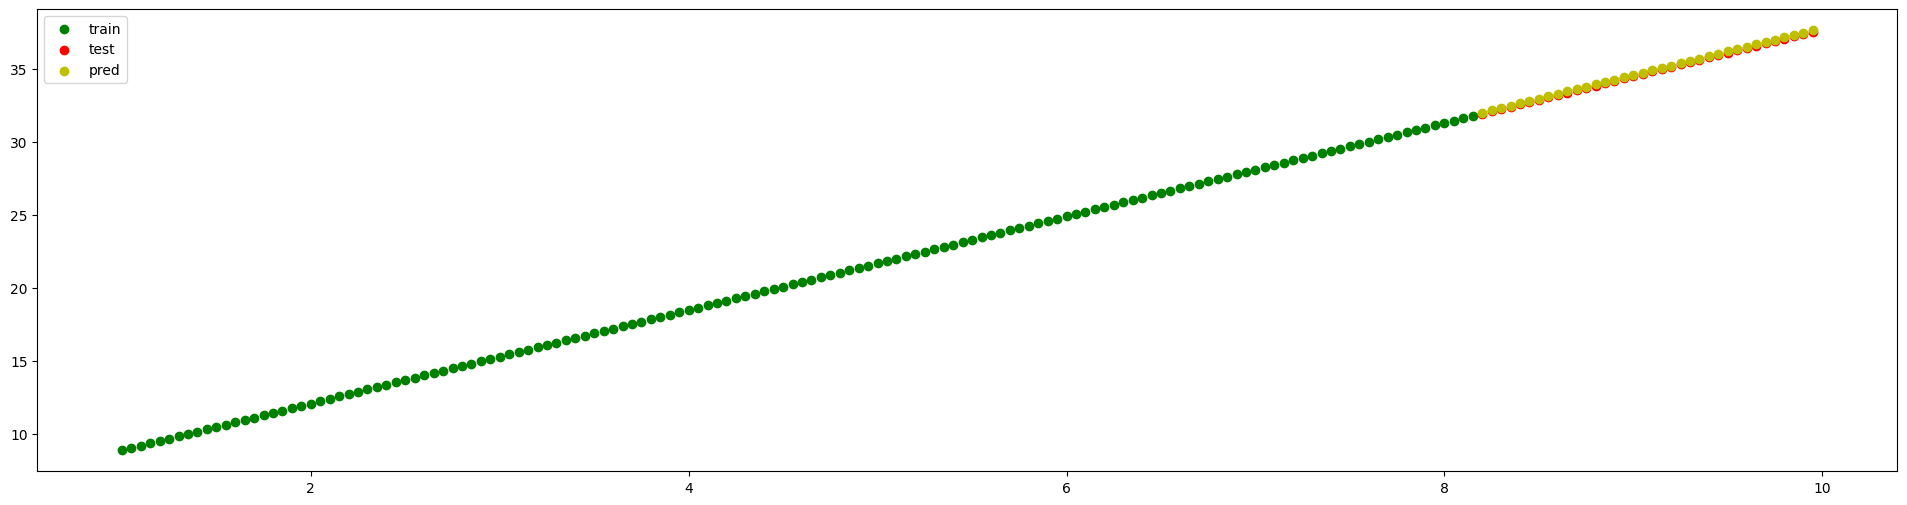

In [24]:
plot(train=(X_train, y_train), test=(X_test, y_test), pred = y_p)

In [25]:
round(Wi.data, 2), round(bi.data, 2), m, bz # autograd for scalar linear regression works good :)

(3.22, 5.58, 3.2, 5.7)

In [26]:
import torch

In [27]:
# understanding broadcasting to try 2-D tensor manipulation and arthematics

# rules:
# starting from the trailing dimension for 2 matrices or tensors
# the dimensions should either match, be 0 or be 1

# for example

t_ones = torch.ones(3) # this is a (3, ) vector
print(t_ones, t_ones.shape) # verifying

t_rand = torch.rand((2, 3)) # this is a (2, 3) tensor
print(t_rand, t_rand.shape)

# here:
# (3, 1) -> this will become 2, 3
# (2, 3)

tensor([1., 1., 1.]) torch.Size([3])
tensor([[0.9775, 0.0232, 0.9882],
        [0.0272, 0.6204, 0.0755]]) torch.Size([2, 3])


In [28]:
# trying addition
t_ones + t_rand

tensor([[1.9775, 1.0232, 1.9882],
        [1.0272, 1.6204, 1.0755]])

In [29]:
# rebuild value class for tensor specific operations.

# helper functions for tensor manipulation

def _to_ndarray(x):
    if isinstance(x, Value): return x
    if isinstance(x, (int, float)): return Value(np.array(x, dtype=float))
    if isinstance(x, np.ndarray): return Value(x.astype(float, copy=False))
    raise TypeError(f"Unsupported Operand: {type(x)}")

def _zero_like(x):
    return np.zeros_like(x, dtype=float)


def _unbroadcast(grad, shape):
    """Sum grad along axes that were broadcast in the forward pass to match 'shape'."""
    # If grad has extra leading dims, sum them away
    while grad.ndim > len(shape):
        grad = grad.sum(axis=0)
    # Sum over dims where target shape is 1
    for i, (gdim, sdim) in enumerate(zip(grad.shape, shape)):
        if sdim == 1 and gdim != 1:
            grad = grad.sum(axis=i, keepdims=True)
    return grad

In [30]:
# implementing tensor

import numpy as np
import math

In [35]:
class tensor:
    def __init__(self, data, _children=(), _op=''):
        if isinstance(data, tensor):
            data = data.data
        if isinstance(data, (int, float)):
            data = np.array(data, dtype=float)             
        elif not isinstance(data, np.ndarray):
            data = np.array(data, dtype=float)
        else:
            data = data.astype(float, copy=False)
        self.data = data
        self._op = _op
        self.grad = np.zeros_like(self.data, dtype=float)
        self._prev = set(_children)
        self._backward = lambda: None

    def __repr__(self):
        return f'tensor(data={self.data}, grad={self.grad} shape={self.data.shape})'  

    @property
    def shape(self):
        return self.data.shape

    def zero_grad(self):
        self.grad[...] = 0.0

    @staticmethod
    def _coerce(x):                                         
        return x if isinstance(x, tensor) else tensor(x)

    @staticmethod
    def _unbroadcast(grad, shape):
        g = grad
        while g.ndim > len(shape):
            g = g.sum(axis=0)
        for i, (gd, sd) in enumerate(zip(g.shape, shape)):
            if sd == 1 and gd != 1:
                g = g.sum(axis=i, keepdims=True)
        return g

    def __getitem__(self, idx):
        out = tensor(self.data[idx], (self,), 'getitem')
        def _backward():
            g = np.zeros_like(self.data, dtype=float)
            np.add.at(g, np.index_exp[idx], out.grad)       
            self.grad += g
        out._backward = _backward
        return out

    def __add__(self, other):
        other = tensor._coerce(other)
        out = tensor(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad  += tensor._unbroadcast(out.grad, self.shape)
            other.grad += tensor._unbroadcast(out.grad, other.shape)
        out._backward = _backward
        return out
    __radd__ = __add__

    def __neg__(self):
        return self * -1.0

    def __sub__(self, other):
        return self + (-tensor._coerce(other))
    def __rsub__(self, other):
        return tensor._coerce(other) + (-self)              

    def __mul__(self, other):
        other = tensor._coerce(other)
        out = tensor(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad  += tensor._unbroadcast(other.data * out.grad, self.shape)
            other.grad += tensor._unbroadcast(self.data  * out.grad, other.shape)
        out._backward = _backward
        return out
    __rmul__ = __mul__

    def __truediv__(self, other):
        return self * (tensor._coerce(other) ** -1)
    def __rtruediv__(self, other):
        return tensor._coerce(other) * (self ** -1)

    def __pow__(self, p):
        if isinstance(p, (int, float)):
            out = tensor(self.data ** p, (self,), '**')
            def _backward():
                self.grad += p * (self.data ** (p - 1.0)) * out.grad
            out._backward = _backward
            return out
        p = tensor._coerce(p)
        out = tensor(self.data ** p.data, (self, p), '**')
        def _backward():
            eps = 1e-12
            self.grad += tensor._unbroadcast(p.data * (self.data ** (p.data - 1.0)) * out.grad, self.shape)
            p.grad    += tensor._unbroadcast(out.data * np.log(np.maximum(self.data, eps)) * out.grad, p.shape)
        out._backward = _backward
        return out

    def tanh(self):
        y = np.tanh(self.data)
        out = tensor(y, (self,), 'tanh')                    
        def _backward():
            self.grad += (1.0 - y*y) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        y = np.exp(self.data)
        out = tensor(y, (self,), 'exp')                     
        def _backward():
            self.grad += y * out.grad
        out._backward = _backward
        return out

    def relu(self):
        y = np.where(self.data > 0, self.data, 0.0)
        out = tensor(y, (self,), 'relu')                    
        def _backward():
            self.grad += (self.data > 0).astype(float) * out.grad
        out._backward = _backward
        return out

    def sum(self, axis=None, keepdims=False):
        out = tensor(self.data.sum(axis=axis, keepdims=keepdims), (self,), 'sum')
        def _backward():
            g = out.grad
            if axis is not None and not keepdims:
                axes = [axis] if isinstance(axis, int) else list(axis)
                for a in axes:
                    g = np.expand_dims(g, axis=a)
            self.grad += np.broadcast_to(g, self.shape)
        out._backward = _backward
        return out

    def mean(self, axis=None, keepdims=False):
        if axis is None:
            count = self.data.size
        else:
            reduced = self.data.sum(axis=axis, keepdims=keepdims)
            count = reduced.size
        return self.sum(axis=axis, keepdims=keepdims) * (1.0 / count)

    def reshape(self, *shape):
        out = tensor(self.data.reshape(*shape), (self,), 'reshape')
        def _backward():
            self.grad += out.grad.reshape(self.shape)
        out._backward = _backward
        return out

    @property
    def T(self):
        out = tensor(self.data.T, (self,), 'transpose')
        def _backward():
            self.grad += out.grad.T
        out._backward = _backward
        return out

    def __matmul__(self, other):
        other = tensor._coerce(other)
        A, B = self.data, other.data

        # guard 2D shapes (clear errors early)                         
        if A.ndim != 2 or B.ndim != 2:
            raise ValueError(f"matmul supports 2D@2D, got {A.shape} @ {B.shape}")
        if A.shape[1] != B.shape[0]:
            raise ValueError(f"inner dims mismatch: {A.shape} @ {B.shape}")

        Y = A @ B
        out = tensor(Y, (self, other), '@')
        def _backward():
            dY = out.grad
            self.grad  += dY @ B.T
            other.grad += A.T @ dY
        out._backward = _backward
        return out

    def backward(self):
        topo, visited = [], set()
        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build(child)
                topo.append(v)
        build(self)
        self.grad = np.ones_like(self.data, dtype=float)
        for v in reversed(topo):
            v._backward()


In [36]:
# keep your old Value class for scalar experiments
# use Tensor for tensor ops

# elementwise + broadcasting
x = tensor(np.ones((3,1)))
v = tensor(np.array([2.0, 3.0]))
y = ((x + v) ** 2).sum()
y.backward()
print(x.grad.shape)  # (3,1)
print(v.grad.shape)  # (2,)

# 2D matmul
A = tensor(np.random.randn(4,3))
B = tensor(np.random.randn(3,5))
L = (A @ B).sum()
L.backward()
print(A.grad.shape, B.grad.shape)  # (4,3) (3,5)




(3, 1)
(2,)
(4, 3) (3, 5)


In [38]:
# linear layer

class linear:
    def __init__(self, in_features, out_features):
        limit = np.sqrt(6.0/ in_features + out_features)
        self.W = tensor(np.random.uniform(-limit, limit, size=(in_features, out_features)))
        self.b = tensor(np.zeros(out_features, dtype=float))
        self.params = [self.W, self.b]

    def __call__(self, x):
        return x @ self.W + self.b 

In [62]:
# create dataset

def create_dataset(n=512, seed=None):
    rng = np.random.default_rng(seed)
    X = rng.uniform(low=-2.5, high=2.5, size=(n, 2)) # (N, 2)
    y = np.sin(X[:, 0:1]) + np.cos(X[:, 1:2]) # (N, 1)
    y += 0.1 * rng.standard_normal(y.shape) # noise
    return (X, y)

In [63]:
X, y = create_dataset(seed=123)

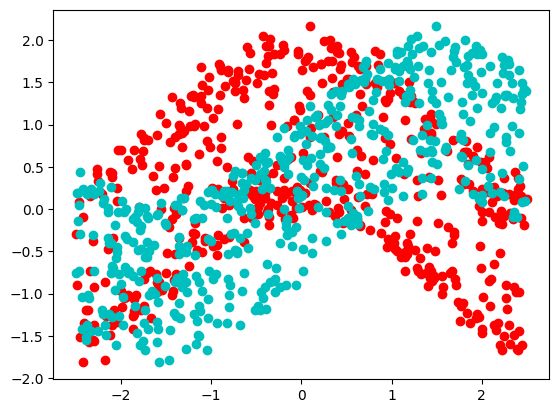

In [72]:
plt.scatter(X[:, 1], y, c='r')
plt.scatter(X[:, 0], y, c='c')

In [73]:
X_t, y_t = tensor(X), tensor(y)

In [79]:
# creating a tiny MLP
def glorot(shape, rng=np.random.default_rng(0)):
    fan_in, fan_out = shape[0], shape[1]
    limit = np.sqrt(6.0/fan_in + fan_out)
    return rng.uniform(-limit, limit, size=shape).astype(float)

In [98]:
W1 = tensor(glorot((2, 16)))
b1 = tensor(np.zeros((16,), dtype=float))
W2 = tensor(glorot((16, 1)))
b2 = tensor(np.zeros((1,), dtype=float))

params = [W1, b1, W2, b2]

In [107]:
def forward(X):
    # X: (N,2)
    h = (X @ W1 + b1).relu()   # (N,16)
    yhat = (h @ W2) + b2       # (N,1)
    return yhat

def mse_loss(yhat, ytrue):
    return ((ytrue - yhat)**2).mean()

In [108]:
epoch = 30
lr = 1e-4

for i in range(epoch):
    # fp
    yhat = forward(X)

    # loss
    loss = mse_loss(yhat, y)

    # zero grad
    for p in params:
        p.zero_grad()

    # backward
    loss.backward()

    # step -- update
    for p in params:
        p.data += -lr * p.grad

    if i % 10 ==0:
        print(f'epoch: {i} | loss: {loss}')

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [105]:
a = np.random.uniform(-1, 1, (512, 2))
b = np.random.uniform(-1, 1, (2, 16))
c = np.random.uniform(-1, 1, (2, ))

In [106]:
c

array([ 0.62978634, -0.28409387])